#  Initial Data Exploration

In [24]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
### Include all quantitative features. In addition, 'std_from_poi' and
### 'std_to_poi' are standardized feature (see details below).
features_list = ['poi','salary', 'deferral_payments',
                 'loan_advances', 'bonus', 'restricted_stock_deferred',
                 'deferred_income', 'expenses',
                 'exercised_stock_options', 'other', 'long_term_incentive',
                 'restricted_stock', 'director_fees','shared_receipt_with_poi',
                 'std_from_poi','std_to_poi']
features_list = ['poi','salary',
                 'bonus',
                 'expenses',
                 'exercised_stock_options', 'other',
                 'restricted_stock', 'shared_receipt_with_poi',
                 'std_from_poi','std_to_poi']
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers

### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
# Add new features: std_from_poi and std_to_poi by dividing the message
# to/from poi by the total sent or received messages, respectively.
data_dict.pop('TOTAL')
data_dict.pop('THE TRAVEL AGENCY IN THE PARK')
for key in data_dict:
    if (type(data_dict[key]['from_poi_to_this_person']) == int and
        type(data_dict[key]['from_messages']) == int):
        data_dict[key]['std_from_poi'] = \
        (data_dict[key]['from_poi_to_this_person']/
         data_dict[key]['from_messages'])
    else:
        data_dict[key]['std_from_poi'] = 0
        #print data_dict[key]['std_from_poi']
    if (type(data_dict[key]['from_this_person_to_poi']) == int and
        type(data_dict[key]['to_messages']) == int):
        data_dict[key]['std_to_poi'] = \
        (data_dict[key]['from_this_person_to_poi']/
         data_dict[key]['to_messages'])
    else:
        data_dict[key]['std_to_poi'] = 0
        
my_dataset = data_dict
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
# The followings are the major steps in the analysis:
# A. Visualize the data using dimensionality reduction PCA and LDA to gain
#    further insight into the data
# B. Algorithm selection using repeated nested cross validation to choose
#    the algorithm that has highest accuracy
# C. Model selection using repeated cross validation to identify the best
#    hyperparameter values

# The following classification algorithms are used:
# 1. Logistic Regression
# 2. Random Forest Classifier
# 3. KNN Classifier
# 4. Support Vector Classifier
# 5. Neural Network: Multi-layer Perceptron Classifier
from __future__ import division
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from time import time

# For simplicity, rename features as X and labels as y
X = features
y = labels
### First, explore the dataset.
### Identify the total number of data points.
print 'Total number of data points:',np.shape(X)[0]
print 'Total number of features:', np.shape(X)[1]

X_std = StandardScaler().fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_std)
print 'PCA explained_variance_ratio_', pca.explained_variance_ratio_

Total number of data points: 141
Total number of features: 9
PCA explained_variance_ratio_ [ 0.39862915  0.16349011  0.11261164  0.09524408  0.08203634  0.04979186
  0.03617784  0.03479835  0.02722062]


#  Scatterplot Matrix

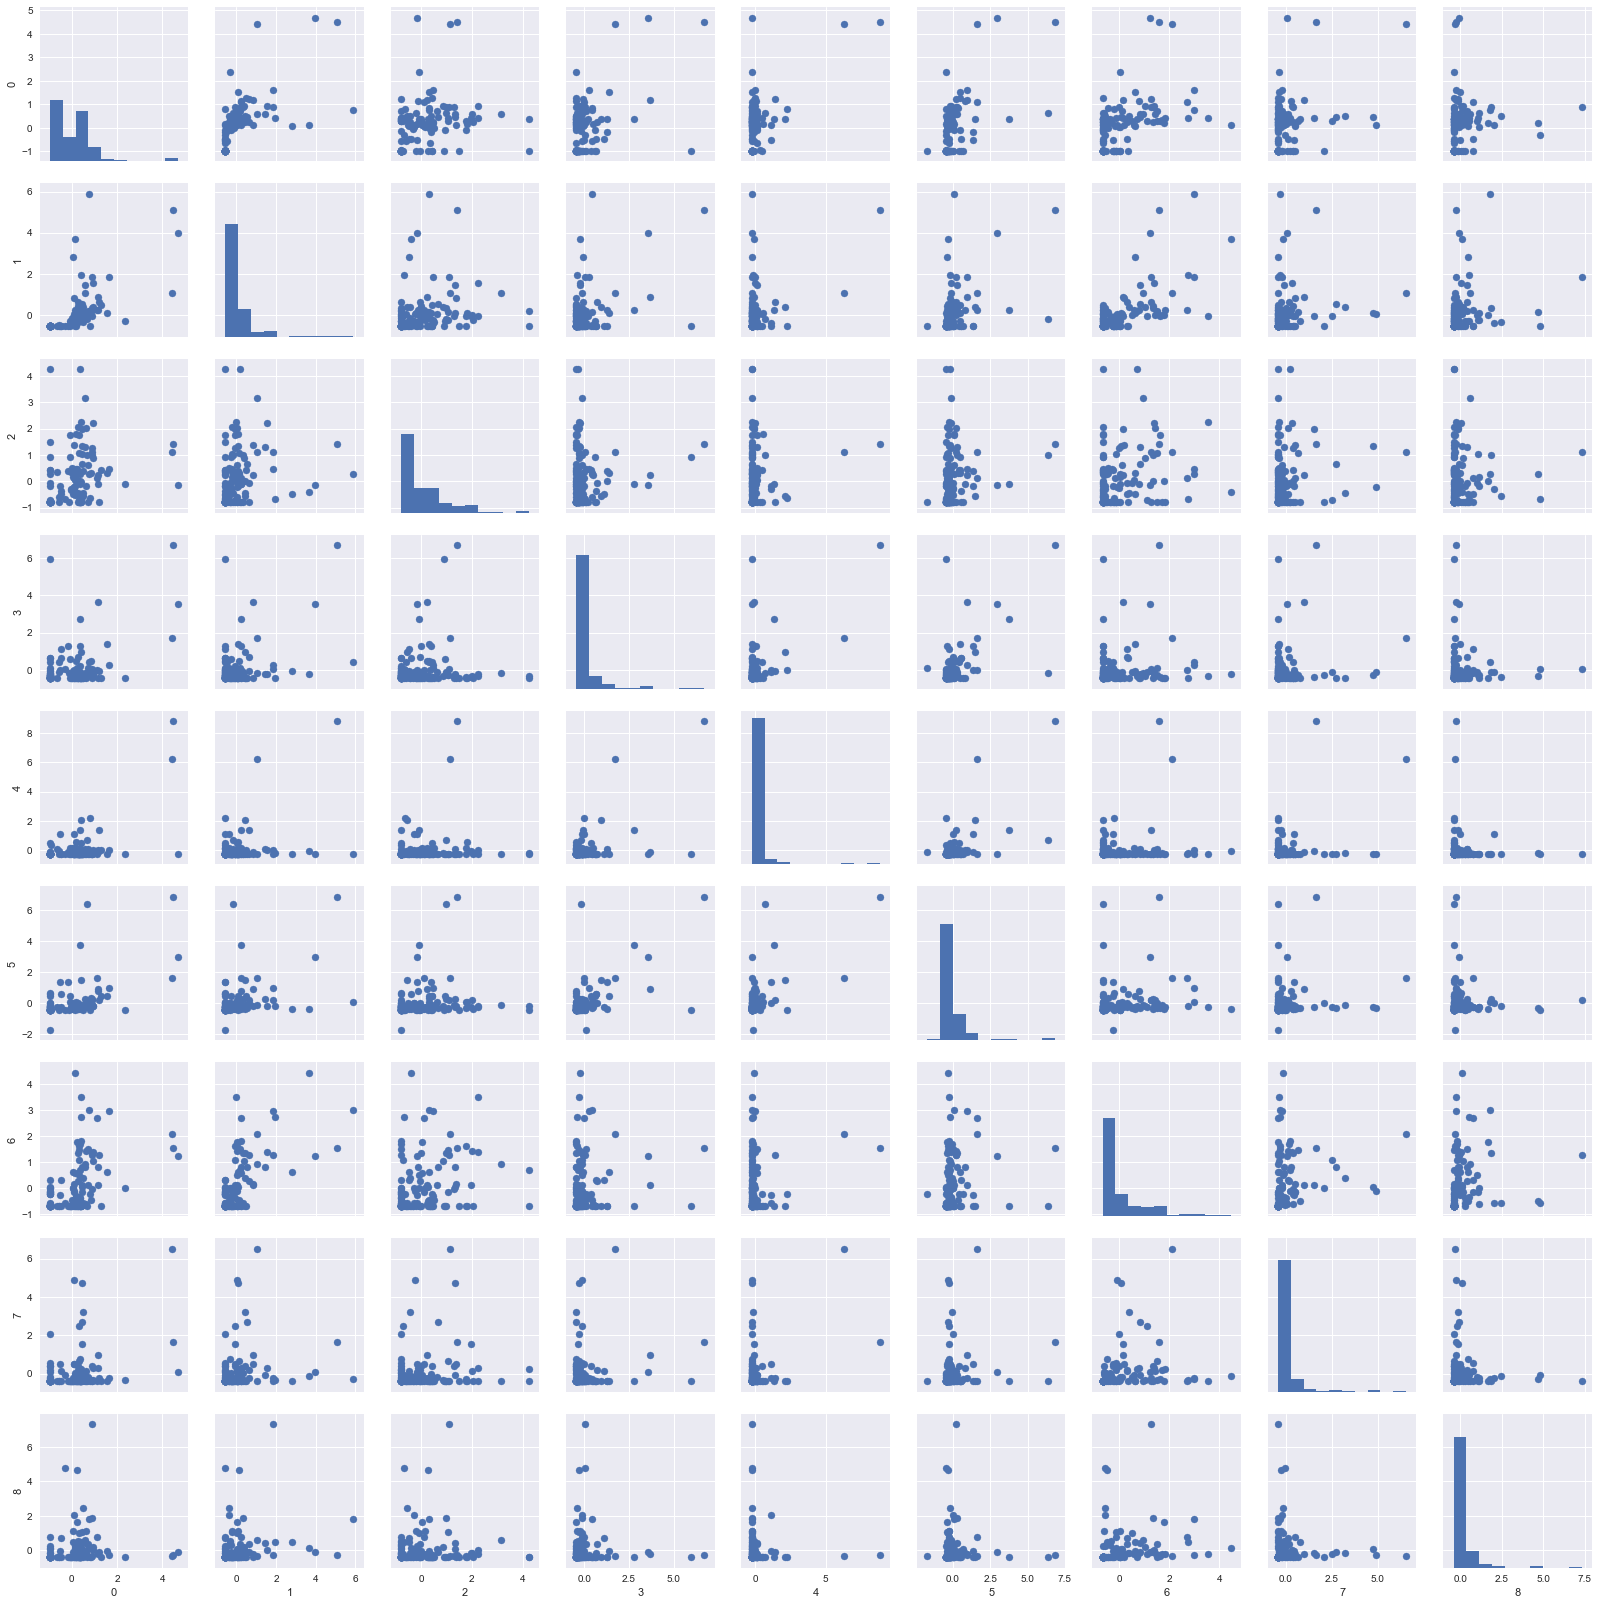

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(X_std)
pg = sns.PairGrid(df)
pg.map_diag(plt.hist)
pg.map_offdiag(plt.scatter)
plt.show()

#  Logistic Regression

In [16]:
clf_labels = \
['Logistic Regression','KNN','Random Forest','SVC','Kernel SVC','MLP']

#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#Logistic Regression
scores=[]
clf_lr = LogisticRegression(penalty='l2')
pipe_lr = Pipeline([['sc',StandardScaler()],
                    ['clf',clf_lr]])
params_lr = {'clf__C':10.0**np.arange(-4,4)}
t0 = time()
for i in range(N_outer):
    k_fold_outer = StratifiedShuffleSplit(n_splits=5,random_state=i)
    for j in range(N_inner):
        k_fold_inner = StratifiedShuffleSplit(n_splits=5,random_state=j)
        gs_lr = GridSearchCV(estimator=pipe_lr,param_grid=params_lr,
                             cv=k_fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_lr,X,y,cv=k_fold_outer,
                                      scoring='f1'))
print 'CV F1 Score of Logistic Regression: %.3f +/- %.3f' %(np.mean(scores),np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)
        
t0 = time()
for i in range(N_outer):
    k_fold_outer = StratifiedShuffleSplit(n_splits=5,random_state=i)
    for j in range(N_inner):
        k_fold_inner = StratifiedShuffleSplit(n_splits=5,random_state=j)
        gs_lr = GridSearchCV(estimator=pipe_lr,param_grid=params_lr,
                             cv=k_fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_lr,X,y,cv=k_fold_outer,
                                      scoring='precision'))
print 'CV Precision Score of Logistic Regression: %.3f +/- %.3f' %(np.mean(scores),np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)
        
t0 = time()
for i in range(N_outer):
    k_fold_outer = StratifiedShuffleSplit(n_splits=5,random_state=i)
    for j in range(N_inner):
        k_fold_inner = StratifiedShuffleSplit(n_splits=5,random_state=j)
        gs_lr = GridSearchCV(estimator=pipe_lr,param_grid=params_lr,
                             cv=k_fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_lr,X,y,cv=k_fold_outer,
                                      scoring='recall'))
        
print 'CV Recall Score of Logistic Regression: %.3f +/- %.3f' %(np.mean(scores),np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)

/Users/Raga/anaconda/envs/enron/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


CV F1 Score of Logistic Regression: 0.213 +/- 0.284
Complete in 37.3 sec


/Users/Raga/anaconda/envs/enron/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


CV Precision Score of Logistic Regression: 0.223 +/- 0.332
Complete in 44.1 sec
CV Recall Score of Logistic Regression: 0.241 +/- 0.318
Complete in 40.6 sec


#  Random Forest Classifier

In [17]:
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#Random Forest Classifier
scores=[]
clf_rf = RandomForestClassifier(random_state=42)
pipe_rf = Pipeline([['sc',StandardScaler()],
                    ['clf',clf_rf]])
params_rf = {'clf__n_estimators':np.arange(1,11)}
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=params_rf,
                             cv=fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_rf,X,y,cv=fold_outer,
                                      scoring='f1'))
print ('CV F1 Score of Random Forest Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=params_rf,
                             cv=fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_rf,X,y,cv=fold_outer,
                                      scoring='precision'))
print ('CV Precision Score of Random Forest Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=params_rf,
                             cv=fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_rf,X,y,cv=fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of Random Forest Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

CV F1 Score of Random Forest Classifier: 0.244 +/- 0.281
Complete in 235.6 sec
CV Precision Score of Random Forest Classifier: 0.245 +/- 0.304
Complete in 466.0 sec
CV Recall Score of Random Forest Classifier: 0.259 +/- 0.303
Complete in 692.5 sec


#  KNN Classifier

In [18]:
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#KNN Classifier
scores=[]
clf_knn = KNeighborsClassifier()
pipe_knn = Pipeline([['sc',StandardScaler()],
                     ['clf',clf_knn]])
params_knn = {'clf__n_neighbors':np.arange(1,6)}
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_knn = GridSearchCV(estimator=pipe_knn,param_grid=params_knn,
                              cv=fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_knn,X,y,cv=fold_outer,
                                      scoring='f1'))
print ('CV F1 Score of KNN Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_knn = GridSearchCV(estimator=pipe_knn,param_grid=params_knn,
                              cv=fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_knn,X,y,cv=fold_outer,
                                      scoring='precision'))
print ('CV Precision Score of KNN Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_knn = GridSearchCV(estimator=pipe_knn,param_grid=params_knn,
                              cv=fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_knn,X,y,cv=fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of KNN Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

CV F1 Score of KNN Classifier: 0.203 +/- 0.277
Complete in 29.2 sec
CV Precision Score of KNN Classifier: 0.229 +/- 0.331
Complete in 30.0 sec
CV Recall Score of KNN Classifier: 0.225 +/- 0.306
Complete in 29.5 sec


#  Linear SVC

In [19]:
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#Linear SVC
scores=[]
clf_svc = SVC()
pipe_svc = Pipeline([['sc',StandardScaler()],
                     ['clf',clf_svc]])
params_svc = {'clf__C':10.0**np.arange(-4,4)}
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_svc = GridSearchCV(estimator=pipe_svc,param_grid=params_svc,
                              cv=fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_svc,X,y,cv=fold_outer,
                                      scoring='f1'))
print ('CV F1 Score of Linear SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_svc = GridSearchCV(estimator=pipe_svc,param_grid=params_svc,
                              cv=fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_svc,X,y,cv=fold_outer,
                                      scoring='precision'))
print ('CV Precision Score of Linear SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_svc = GridSearchCV(estimator=pipe_svc,param_grid=params_svc,
                              cv=fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_svc,X,y,cv=fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of Linear SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

CV F1 Score of Linear SVC: 0.128 +/- 0.233
Complete in 40.5 sec
CV Precision Score of Linear SVC: 0.129 +/- 0.254
Complete in 40.5 sec
CV Recall Score of Linear SVC: 0.130 +/- 0.257
Complete in 39.8 sec


#  Kernel SVC

In [20]:
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#Kernel SVC
scores=[]
clf_ksvc = SVC(kernel='rbf')
pipe_ksvc = Pipeline([['sc',StandardScaler()],
                     ['clf',clf_ksvc]])
params_ksvc = {'clf__C':10.0**np.arange(-4,4),'clf__gamma':10.0**np.arange(-4,4)}
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_ksvc = GridSearchCV(estimator=pipe_ksvc,param_grid=params_ksvc,
                               cv=fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_ksvc,X,y,cv=fold_outer,
                                      scoring='f1'))
print ('CV F1 Score of Kernel SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_ksvc = GridSearchCV(estimator=pipe_ksvc,param_grid=params_ksvc,
                               cv=fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_ksvc,X,y,cv=fold_outer,
                                      scoring='precision'))
print ('CV Precision Score of Kernel SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_ksvc = GridSearchCV(estimator=pipe_ksvc,param_grid=params_ksvc,
                               cv=fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_ksvc,X,y,cv=fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of Kernel SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

CV F1 Score of Kernel SVC: 0.062 +/- 0.173
Complete in 338.1 sec
CV Precision Score of Kernel SVC: 0.060 +/- 0.186
Complete in 675.4 sec
CV Recall Score of Kernel SVC: 0.064 +/- 0.186
Complete in 1027.5 sec


#  Naive Bayes

In [21]:
#Set the number of repeats of the cross validation
N_outer = 5

#Naive Bayes
scores=[]
clf_nb = GaussianNB()
pipe_nb = Pipeline([['sc',StandardScaler()],
                    ['clf',clf_nb]])
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    scores.append(cross_val_score(pipe_nb,X,y,cv=fold_outer,
                                      scoring='f1'))
print 'CV F1 Score of Naive Bayes: %.3f +/- %.3f' %(np.mean(scores),
                                                               np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    scores.append(cross_val_score(pipe_nb,X,y,cv=fold_outer,
                                      scoring='precision'))
print 'CV Precision Score of Naive Bayes: %.3f +/- %.3f' %(np.mean(scores),
                                                               np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    scores.append(cross_val_score(pipe_nb,X,y,cv=fold_outer,
                                      scoring='recall'))
print 'CV Recall Score of Naive Bayes: %.3f +/- %.3f' %(np.mean(scores),
                                                               np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)

CV F1 Score of Naive Bayes: 0.189 +/- 0.297
Complete in 0.2 sec
CV Precision Score of Naive Bayes: 0.206 +/- 0.336
Complete in 0.1 sec
CV Recall Score of Naive Bayes: 0.198 +/- 0.318
Complete in 0.2 sec


#  Multi-Layer Perceptron

In [22]:
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#Kernel SVC
scores=[]
clf_mlp = MLPClassifier(solver='lbfgs')
pipe_mlp = Pipeline([['sc',StandardScaler()],
                     ['clf',clf_mlp]])
params_mlp = {'clf__activation':['logistic','relu'],'clf__alpha':10.0**np.arange(-4,4)}
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_mlp = GridSearchCV(estimator=pipe_mlp,param_grid=params_mlp,
                               cv=fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_mlp,X,y,cv=fold_outer,
                                      scoring='f1'))
print ('CV F1 Score of MLP: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_mlp = GridSearchCV(estimator=pipe_mlp,param_grid=params_mlp,
                               cv=fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_mlp,X,y,cv=fold_outer,
                                      scoring='precision'))
print ('CV Precision of MLP: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5, random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5, random_state=j)
        gs_mlp = GridSearchCV(estimator=pipe_mlp,param_grid=params_mlp,
                               cv=fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_mlp,X,y,cv=fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of MLP: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

CV F1 Score of MLP: 0.104 +/- 0.197
Complete in 1501.7 sec
CV Precision of MLP: 0.104 +/- 0.201
Complete in 1527.6 sec
CV Recall Score of MLP: 0.129 +/- 0.224
Complete in 1442.1 sec


#  AdaBoost Classifier

In [ ]:
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#AdaBoost
scores=[]
clf_ada = AdaBoostClassifier(random_state=42)
pipe_ada = Pipeline([['sc',StandardScaler()],
                     ['clf',clf_ada]])
params_ada = {'clf__n_estimators':np.arange(1,11)*10}
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5,random_state=j)
        gs_ada = GridSearchCV(estimator=pipe_ada,param_grid=params_ada,
                               cv=fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_ada,X,y,cv=fold_outer,
                                      scoring='f1'))
print ('CV F1 Score of AdaBoost: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedShuffleSplit(n_splits=5,random_state=j)
        gs_ada = GridSearchCV(estimator=pipe_ada,param_grid=params_ada,
                               cv=fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_ada,X,y,cv=fold_outer,
                                      scoring='precision'))
print ('CV F1 Score of AdaBoost: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedShuffleSplit(n_splits=5,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_ada = GridSearchCV(estimator=pipe_ada,param_grid=params_ada,
                               cv=fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_ada,X,y,cv=fold_outer,
                                      scoring='recall'))
print ('CV F1 Score of AdaBoost: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)